# Imports

In [1]:
from collections import defaultdict
from os.path import join as pjoin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 200

%matplotlib inline

DATA_DIR = pjoin('..', 'data', 'raw')
UNK_ID = 0
UNK_VAL = '<unk>'

## Data load

### Sample submission

In [2]:
submission = pd.read_csv(pjoin(DATA_DIR, 'submission.csv'))
print(submission.dtypes)
print(submission.shape)

users_test = set(submission.user_id)
print(f'Users found in train: {len(users_test)}')

assert len(submission) == len(users_test)

submission.head()

user_id      uint64
 movie_id    object
dtype: object
(1695, 2)
Users found in train: 1695


user_id   movie_id
0  16975709365084587137  0 0 0 0 0
1  10225505309438393880  0 0 0 0 0
2    337894458057354820  0 0 0 0 0
3  16389753737490268206  0 0 0 0 0
4  12377183607123393787  0 0 0 0 0

### Watch History

In [3]:
views_db = pd.read_csv(
    pjoin(DATA_DIR, 'movies_dataset_10 months.csv'),
    parse_dates=['ts']
)

views_db['month'] = views_db['ts'].dt.month.astype(np.uint8)
views_db['year'] = views_db['ts'].dt.year.astype(np.uint16)
views_db['weekday'] = views_db['ts'].dt.weekday.astype(np.uint8)
views_db['monthday'] = views_db['ts'].dt.day.astype(np.uint8)

print(views_db.dtypes)
print(views_db.shape)

users_train = set(views_db.user_id)
print(f'Users found in train: {len(users_train)}')
print(
    f'Test users found in train: '
    f'{len(users_test & users_train)}/{len(users_test)}'
)

views_db.head()

ts            datetime64[ns]
user_id               uint64
movie_id               int64
episode_id             int64
month                  uint8
year                  uint16
weekday                uint8
monthday               uint8
dtype: object
(346408, 8)
Users found in train: 2055
Test users found in train: 1695/1695


ts               user_id  movie_id  episode_id  month  \
0 2019-10-01 00:01:31   6582736606368231689     15391       81786     10   
1 2019-10-01 00:01:38    750594023898082561     17539      104006     10   
2 2019-10-01 00:01:57   2110694416164715906     11324           0     10   
3 2019-10-01 00:02:41  16763157513451692176     15498           0     10   
4 2019-10-01 00:03:17  15301363348200942035     11195           0     10   

   year  weekday  monthday  
0  2019        1         1  
1  2019        1         1  
2  2019        1         1  
3  2019        1         1  
4  2019        1         1

In [4]:
# "episodic" movies
episodic = views_db.groupby('movie_id')['episode_id'].max() > 0
episodic.value_counts()

False    4120
True      723
Name: episode_id, dtype: int64

### Movie DB

In [5]:
movie_db = pd.read_csv(pjoin(DATA_DIR, 'movies.csv')).rename(columns={'id':'movie_id'}).set_index('movie_id')
assert len(movie_db) == movie_db.index.nunique()
print(f'Movie db shape: {movie_db.shape}')
print(movie_db.replace('', np.nan).isnull().sum())

Movie db shape: (19265, 15)
year                 0
title             1983
description       6460
genres            2120
director          1626
actors            2094
writers           9055
music            11323
art              11735
producer         12622
imdb_id           4048
tmdb_id           5364
imdb_rating       4904
tmdb_rating       5626
available_now        0
dtype: int64


In [6]:
movie_db.head()

year                                  title  \
movie_id                                                
1         2008                   The Girl from Monaco   
2         2008                  Every Jack has a Jill   
3         2009                            Dorian Gray   
4         2008  How to Lose Friends & Alienate People   
5         2009                               Cell 211   

                                                                                                                                                                                                      description  \
movie_id                                                                                                                                                                                                            
1         A brilliant and neurotic attorney goes to Monaco to defend a famous criminal. But, instead of focusing on the case, he falls for a beautiful she-devil, who turns him into a complete wreck... Hopef...   
2         Jack is encouraged to take the romantic Paris vacation he won, despite just being dumped by his girlfriend. His trip soon devolves into chaos and adventure, when his luggage is swapped for a Frenc...   
3         A vain London playboy offers his soul in exchange for eternal beauty in this adaptation of the chilling tale by author Oscar Wilde. Seduced into the decadent world of Lord Henry Wotton (Colin Firt...   
4                                                          A British writer struggles to fit in at a high-profile magazine in New York. Based on Toby Young's memoir "How to Lose Friends &amp; Alienate People".   
5         The story of two men on different sides of a prison riot -- the inmate leading the rebellion and the young guard trapped in the revolt, who poses as a prisoner in a desperate attempt to survive th...   

                    genres            director  \
movie_id                                         
1             Comedy,Drama       Anne Fontaine   
2         Comedy,Melodrama  Jennifer Devoldère   
3          Thriller,Sci-Fi       Oliver Parker   
4             Comedy,Drama    Robert B. Willow   
5          Action,Thriller       Daniel Monzon   

                                                                                                                                                                                     actors  \
movie_id                                                                                                                                                                                      
1                      Fabrice Luchini,Helene de Saint-Pere,Jeanne Balibar,Philippe Duclos,Alexandre Steiger,Gilles Cohen,Stéphane Audran,Rushdie Zem,Christophe Vandevelde,Louise Bourgoin   
2                                 Justin Lee Bartha,Billy Boyd,Maurice Bénichou,Melanie Laurent,Valérie Benguigui,Géraldine Nakache,Yvon Back,Dorothée Berryman,Jessica Paré,Jacky Berroyer   
3         Colin Firth,Nathan Rosen,Caroline Goodall,John Hollingworth,Pip Torrens,Fiona Shaw,Rebecca Hall,Ben Chaplin,Benjamin Thomas "Ben" Barnes,Jeff Lipman,Emilia Fox,Rachel heard wood   
4                                                 Simon Pegg,Jeff Bridges,Danny Huston,Jillian Anderson,Kirsten Dunst,Megan Fox,Kelan Pannell,Janette Scott,Kelly Jo Charge,Christian Smith   
5                                       Luis Tosar,Vicente Romero,Fernando Soto,Luis Zahera,Martha Etara,Carlos Bardem,Manuel Morón,Antonio Resines,Manolo Solo,Felix Cubero,Alberto Ammann   

                                                      writers           music  \
movie_id                                                                        
1                                Anne Fontaine,Benoît Graffin  Philippe Rombi   
2                                          Jennifer Devoldère             NaN   
3                                     Toby Finlay,Oscar Wilde    Charlie Mole   
4                       

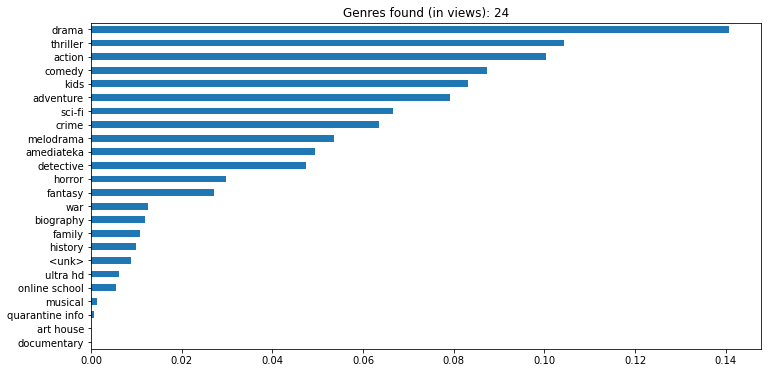

In [7]:
# extract genres
genres = movie_db.genres.str.lower().str.strip().str.split(',').explode()\
.value_counts(ascending=True, normalize=True)

plt.figure(figsize=(12, 6))
genres.plot(kind='barh', title=f'Genres found (in movies): {len(genres)}')


genres_train = (
    views_db.movie_id.map(movie_db.genres).replace('', np.nan)
    .fillna(UNK_VAL).astype('str')
    .str.lower().str.strip().str.split(',')
    .explode().value_counts(ascending=True, normalize=True)
)

plt.figure(figsize=(12, 6))
genres_train.plot(kind='barh', title=f'Genres found (in views): {len(genres_train)}')
pass

## Encode categorical features

- movie genres
- user_ids (dense pack)
- director
- actors
- etc.
- **drop useless** (writer, art, ...)

In [8]:
cat_dict = defaultdict(dict)

# users
cat_dict['user_id_to_id'] = {u:i+1 for i,u in enumerate(sorted(users_train | users_test - {UNK_VAL}))}
cat_dict['user_id_to_id'][UNK_VAL] = 0
cat_dict['id_to_user_id'] = {v:k for (k,v) in cat_dict['user_id_to_id'].items()}
print(f"# users: {len(cat_dict['user_id_to_id'])}")

# genres
cat_dict['genre_to_id'] = {g:i+1 for i,g 
                           in enumerate(sorted(set(genres.index) | set(genres_train.index) - {UNK_VAL}))} 
cat_dict['genre_to_id'][UNK_VAL] = 0
cat_dict['id_to_genre'] = {v:k for (k,v) in cat_dict['genre_to_id'].items()}
print(f"# genres: {len(cat_dict['genre_to_id'])}")

# directors
directors = movie_db.director.str.lower().str.strip().str.split(',').explode().fillna(UNK_VAL).value_counts()
# replace 1film directors with <noname> token
#     directors.index = np.where(directors > 1, directors.index, '<noname>')

cat_dict['director_to_id'] = {d:i+1 for i,d in enumerate(sorted(set(directors.index) - {UNK_VAL}))}
cat_dict['director_to_id'][UNK_VAL] = 0
cat_dict['id_to_director'] = {v:k for (k,v) in cat_dict['director_to_id'].items()}
print(f"# directors: {len(cat_dict['director_to_id'])}")

# actors
actors = movie_db.actors.str.lower().str.strip().str.split(',').explode().fillna(UNK_VAL).value_counts()
# replace 1film actors with <noname> token
#     actors.index = np.where(actors > 1, actors.index, '<noname>')
cat_dict['actor_to_id'] = {a:i+1 for i,a in enumerate(sorted(set(actors.index) - {UNK_VAL}))}
cat_dict['actor_to_id'][UNK_VAL] = 0
cat_dict['id_to_actor'] = {v:k for (k,v) in cat_dict['actor_to_id'].items()}
print(f"# actors: {len(cat_dict['actor_to_id'])}")

# users: 2056
# genres: 29
# directors: 7657
# actors: 39580
